In [25]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from psycopg2 import sql
import psycopg2
import os
import matplotlib.pyplot as plt

In [3]:
# from model import update_price

# update_price(update_db=False)

epsilon set to 0.35, which means we explore 35.0 % of the time
product wine, batch wine_0f395984-f563-42e9-adbf-545e33d99884: exploit. setting price to 24.712046 which generated the highest sales of 494.24092
product rice, batch rice_a46dc9db-a20f-4d68-87a1-6e97deaf12cb: exploit. setting price to 5.866698 which generated the highest sales of 293.3349
product wine, batch wine_05d388dc-dc6e-43b2-9a71-98cb4464f816: exploit. setting price to 24.712046 which generated the highest sales of 494.24092
product rice, batch rice_ce73e293-e799-41c5-bacf-a5b92ba7badf: explore. sampling uniformly between 1 and 6 eur. setting price to 3.795285109189223
product rice, batch rice_0308046f-6615-4b5c-9a25-20f1a0c856e7: explore. sampling uniformly between 1 and 6 eur. setting price to 3.412033843672691
product wine, batch wine_8f431c7f-0ae7-4997-905d-f007e60130e7: exploit. setting price to 24.712046 which generated the highest sales of 494.24092
product wine, batch wine_7b1aa4a1-d970-4cae-8908-6fe0fb8d91fb

In [102]:
from sqlalchemy import create_engine


def load_data():
    database_url = os.environ["DATABASE_URL"]
    engine = create_engine(database_url)

    sales_data_query = """
        SELECT
            st.batch_id,
            b.batch_name,
            st.execution_time AS timestamp,
            b.product AS product,
            b.sell_by AS sell_by,
            st.amount AS stock
        FROM
            stock st
        JOIN
            batchs b ON CAST(b.batch_id AS TEXT) = CAST(st.batch_id AS TEXT)
    """
    sales_data = pd.read_sql_query(sales_data_query, engine)

    price_data_query = """
        SELECT product_name, batch_name, price, start_date FROM prices
    """
    price_data = pd.read_sql_query(price_data_query, engine)

    competitor_data_query = """
        SELECT * FROM competitors
    """
    competitor_data = pd.read_sql_query(competitor_data_query, engine)

    return sales_data, price_data, competitor_data

def preprocess_data(sales_data, price_data, competitor_data):

    sales_and_price_merged = pd.merge_asof(
        sales_data.sort_values("timestamp"),
        price_data.sort_values("start_date"),
        left_on="timestamp",
        right_on="start_date",
        by="batch_name",
        direction="backward"
    )

    competitor_data_preprocessed = (
        competitor_data
        .pivot(
            index=['batch_name', 'execution_time'], 
            columns='competitor', 
            values='price'
        )
        .reset_index()
        .rename(columns=lambda columns: columns.lower())
        
    )

    return (
        pd.merge_asof(
            sales_and_price_merged.sort_values("timestamp"),
            competitor_data_preprocessed.sort_values("execution_time"),
            left_on="timestamp",
            right_on="execution_time",
            by="batch_name",
            direction="backward"
        )
        .assign(stock_diff = lambda df: -df.groupby('batch_id')['stock'].transform('diff'))
        .assign(sales = lambda df: np.where(df.timestamp < df.sell_by, df.price * df.stock_diff, 0))
        .assign(hours_until_perished = lambda df: (df.timestamp - df.sell_by).dt.seconds / 60 / 60)
        # .dropna(subset='sales')
        # .sort_values(['product', 'batch_id', 'timestamp'])
    )

In [103]:
sales_data, price_data, competitor_data = load_data()
df = preprocess_data(sales_data, price_data, competitor_data)

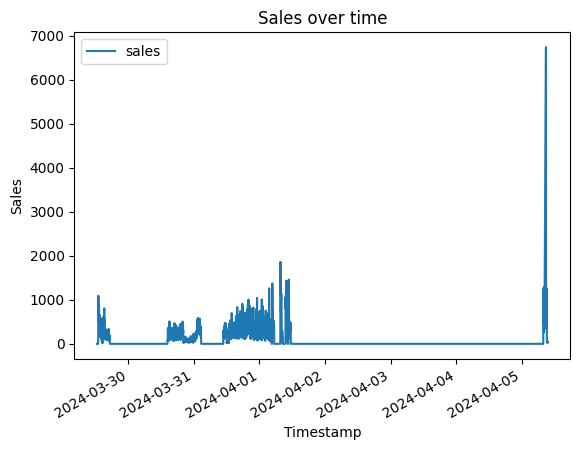

In [106]:

from figures import plot_total_sales


plot_total_sales(df)

In [64]:
preprocessed_df

,batch_id,batch_name,timestamp,product,sell_by,stock,product_name,price,start_date,stock_diff,sales
44223,11668,apples-green_9bc1dbc3-f7f3-45ca-a3e5-9d7f6166db78,2024-03-25 17:30:18.384139,apples-green,2024-03-25 17:38:01.014163,100,rice,2.483255,2024-03-25 17:29:41.390939,-0.0,-0.0
44364,11668,apples-green_9bc1dbc3-f7f3-45ca-a3e5-9d7f6166db78,2024-03-25 17:31:33.088477,apples-green,2024-03-25 17:38:01.014163,100,rice,4.174582,2024-03-25 17:30:57.129940,-0.0,-0.0
44509,11668,apples-green_9bc1dbc3-f7f3-45ca-a3e5-9d7f6166db78,2024-03-25 17:32:48.077251,apples-green,2024-03-25 17:38:01.014163,100,rice,1.193724,2024-03-25 17:32:11.713449,-0.0,-0.0
44695,11668,apples-green_9bc1dbc3-f7f3-45ca-a3e5-9d7f6166db78,2024-03-25 17:34:03.697897,apples-green,2024-03-25 17:38:01.014163,100,rice,2.641447,2024-03-25 17:33:26.517942,-0.0,-0.0
44771,11668,apples-green_9bc1dbc3-f7f3-45ca-a3e5-9d7f6166db78,2024-03-25 17:35:20.131334,apples-green,2024-03-25 17:38:01.014163,100,rice,3.523811,2024-03-25 17:34:42.976510,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...
963379,23912,wine_fba507a3-9427-4a7a-851c-836f814cd043,2024-04-05 09:03:21.187049,wine,2024-04-06 08:28:01.124326,20,wine,22.425642,2024-04-05 09:01:52.358042,-0.0,-0.0
962967,23930,wine_ebf40032-7886-4e56-a862-15012f2bbdd4,2024-04-05 08:54:21.545880,wine,2024-04-06 08:50:00.907014,20,wine,6.794295,2024-04-05 08:52:52.187683,-0.0,-0.0
963055,23930,wine_ebf40032-7886-4e56-a862-15012f2bbdd4,2024-04-05 08:57:20.072490,wine,2024-04-06 08:50:00.907014,20,wine,24.451113,2024-04-05 08:55:52.743802,-0.0,-0.0
963300,23930,wine_ebf40032-7886-4e56-a862-15012f2bbdd4,2024-04-05 09:00:19.526736,wine,2024-04-06 08:50:00.907014,20,wine,24.712046,2024-04-05 08:58:48.945903,-0.0,-0.0


In [62]:
from sqlalchemy import create_engine
import os
import pandas as pd

database_url = os.environ["DATABASE_URL"]
engine = create_engine(database_url)

price_data_query = """
    SELECT * FROM competitors
"""
competitor_data = pd.read_sql_query(price_data_query, engine)

In [60]:
price_data

,product_name,batch_name,price,start_date
0,wine,wine_c20f6358-43ce-4910-b235-421304440c50,13.066534,2024-03-26 11:50:09.396129
1,wine,wine_c5bd1844-369a-44d3-8fa1-e5c1cef63b35,24.073757,2024-03-26 11:50:09.396129
2,wine,wine_ca164da5-397d-4789-a4e4-849fde2230fc,16.624218,2024-03-26 11:50:09.396129
3,wine,wine_cc2b0bd5-6ddb-417d-bc9b-0777c1e52466,10.583390,2024-03-26 11:50:09.396129
4,wine,wine_ce42ee2a-499c-4c37-922a-f36a291ee1d5,16.915445,2024-03-26 11:50:09.396129
...,...,...,...,...
404892,wine,wine_ba83fb9b-679d-433a-a8f5-3308061f1004,22.936277,2024-03-26 11:50:09.396129
404893,wine,wine_bb69d12d-1507-4dc4-95d0-3924e9f2b3a7,6.173442,2024-03-26 11:50:09.396129
404894,wine,wine_bcd80903-cc15-4726-9108-d143299fd199,11.550584,2024-03-26 11:50:09.396129
404895,wine,wine_be09d504-b627-45d2-bde4-21e8ab5c75af,6.729483,2024-03-26 11:50:09.396129


In [ ]:
def preprocess_data(sales_data, price_data):
    return (
        pd.merge_asof(
            sales_data.sort_values("timestamp"),
            price_data.sort_values("start_date"),
            left_on="timestamp",
            right_on="start_date",
            by="batch_name",
            direction="backward"
        )
        .assign(stock_diff = lambda df: -df.groupby('batch_id')['stock'].transform('diff'))
        .assign(sales = lambda df: np.where(df.timestamp < df.sell_by, df.price * df.stock_diff, 0))
        .dropna(subset='sales')
        .sort_values(['product', 'batch_id', 'timestamp'])
    )

In [29]:
def get_X_y(df):
    return df.drop(columns='sales'), df['sales']


X, y = (
    preprocessed_df
    .loc[lambda df: df.sales > 0]
    .assign(product = lambda df: df['product'].astype('category'))
    .assign(hours_until_perished = lambda df: (df.timestamp - df.sell_by).dt.seconds / 60 / 60)
    .loc[:, ['sales', 'product', 'hours_until_perished']]
    .pipe(get_X_y)
)

X, y


(             product  hours_until_perished
 166186  apples-green             23.888889
 166404  apples-green             23.921944
 166683  apples-green             23.955278
 166752  apples-green             23.988611
 167089  apples-green             23.855278
 ...              ...                   ...
 961491          wine              2.721667
 961662          wine              2.771667
 961416          wine              2.338889
 961213          wine              1.255000
 962343          wine              0.905278
 
 [9438 rows x 2 columns],
 166186     69.802030
 166404     50.944437
 166683     14.048384
 166752    107.467171
 167089     11.234778
              ...    
 961491    260.211824
 961662     98.848184
 961416    494.240920
 961213     55.250695
 962343    188.116524
 Name: sales, Length: 9438, dtype: float64)

In [51]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_validate
from models import ridge, gradient_booster

model = gradient_booster.get_model()

cv = KFold(n_splits=5, shuffle=True)

cv_results = cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    return_estimator=True
)

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_validate
from models import ridge, gradient_booster

model = ridge.get_model()

cv = KFold(n_splits=5, shuffle=True)

cv_results = cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    return_estimator=True
)

In [19]:
epsilon = 0.35

price_ranges = {
    'rice': (1, 6),
    'wine': (4, 25),
    'apples-red': (1.2, 4),
    'apples-green': (1.2, 4),
    'bananas': (0.9, 3),
    'bananas-organic': (1.5, 3.5),
    'broccoli': (2, 6),
    'cheese': (7, 25),
    'beef': (10, 30),
    'avocado': (4, 12)
}

print(f'epsilon set to {epsilon}, which means we explore {epsilon*100} % of the time')

unique_batch_names = sales_data.loc[lambda df: df.sell_by > pd.Timestamp.now()]['batch_name'].unique()

prices = []
for batch_name in unique_batch_names:
    product = sales_data.loc[lambda df: df['batch_name'] == batch_name]['product'].values[0]
    if np.random.rand() > epsilon:
        product_df = preprocessed_df.loc[lambda df: df['product'] == product]
        price = product_df.iloc[product_df['sales'].argmax()]['price']
        print(f'product {product}, batch {batch_name}: exploit. setting price to {price} '
            f'which generated the highest sales of {product_df['sales'].max()}')
    else:
        price = np.random.uniform(low=price_ranges[product][0], high=price_ranges[product][1])
        print(f'product {product}, batch {batch_name}: explore. sampling uniformly between '
            f'{price_ranges[product][0]} and {price_ranges[product][1]} eur. setting price to {price}')
    prices.append((product, batch_name, price))

prices_df = (
    pd.DataFrame(prices, columns=['product_name', 'batch_name', 'price'])
    .assign(start_date = pd.Timestamp.now())
    .sort_values(['product_name', 'batch_name', 'price'])
    .reset_index(drop=True)
)

In [95]:
product_df

,batch_id,batch_name,timestamp,product,sell_by,stock,product_name,price,start_date,stock_diff,sales
44076,10570,wine_5202741f-ae97-4ef0-a697-d357f96004d6,2024-03-25 17:30:18.384139,wine,2024-03-25 17:40:01.257532,20,rice,5.706182,2024-03-25 17:29:41.390939,-0.0,-0.0
44282,10570,wine_5202741f-ae97-4ef0-a697-d357f96004d6,2024-03-25 17:31:33.088477,wine,2024-03-25 17:40:01.257532,20,rice,2.491369,2024-03-25 17:30:57.129940,-0.0,-0.0
44403,10570,wine_5202741f-ae97-4ef0-a697-d357f96004d6,2024-03-25 17:32:48.077251,wine,2024-03-25 17:40:01.257532,20,rice,5.624093,2024-03-25 17:32:11.713449,-0.0,-0.0
44591,10570,wine_5202741f-ae97-4ef0-a697-d357f96004d6,2024-03-25 17:34:03.697897,wine,2024-03-25 17:40:01.257532,20,rice,5.605772,2024-03-25 17:33:26.517942,-0.0,-0.0
44868,10570,wine_5202741f-ae97-4ef0-a697-d357f96004d6,2024-03-25 17:35:20.131334,wine,2024-03-25 17:40:01.257532,20,rice,4.247642,2024-03-25 17:34:42.976510,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...
171505,16186,wine_491a4a12-9b5b-4c9a-b5a3-84fd7fd9e063,2024-03-29 13:57:20.361049,wine,2024-03-30 13:50:01.065698,20,wine,18.829960,2024-03-29 13:56:09.004270,-0.0,-0.0
171684,16186,wine_491a4a12-9b5b-4c9a-b5a3-84fd7fd9e063,2024-03-29 13:59:19.800596,wine,2024-03-30 13:50:01.065698,20,wine,9.062145,2024-03-29 13:58:07.956468,-0.0,-0.0
171905,16186,wine_491a4a12-9b5b-4c9a-b5a3-84fd7fd9e063,2024-03-29 14:01:19.902496,wine,2024-03-30 13:50:01.065698,20,wine,24.445082,2024-03-29 14:00:05.099709,-0.0,-0.0
172035,16186,wine_491a4a12-9b5b-4c9a-b5a3-84fd7fd9e063,2024-03-29 14:03:19.853920,wine,2024-03-30 13:50:01.065698,20,wine,9.623322,2024-03-29 14:02:05.125136,-0.0,-0.0


In [ ]:
linspa0.80

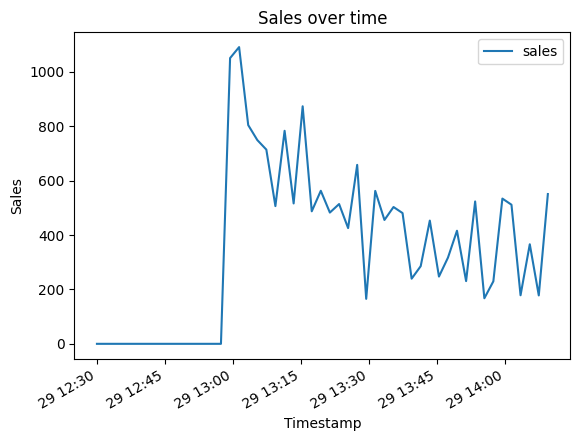

In [33]:
# def plot_total_sales()
    

plot = preprocessed_df.loc[lambda df: df.timestamp > "2024-03-29 12:30:00"].groupby('timestamp').agg(sales = ('sales', 'sum')).plot(title="Sales over time", ylabel="Sales", xlabel="Timestamp")


In [38]:
plot

<Axes: title={'center': 'Sales over time'}, xlabel='Timestamp', ylabel='Sales'>

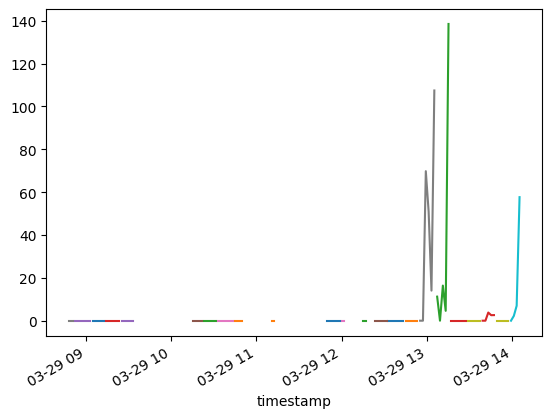

In [7]:
(
    preprocessed_df
    .loc[lambda df: df.timestamp > "2024-03-28 13:00:00"]
    .drop_duplicates("timestamp")
    .pivot(index="timestamp", columns="batch_name", values="sales")
    .plot(legend=False)
)
plt.show()

In [90]:
preprocessed_df.plot(x='timestamp', y='sales', by)

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [18]:
epsilon=0.5

price_ranges = {
    'rice': (1, 6),
    'wine': (4, 25),
    'apples-red': (1.2, 4),
    'apples-green': (1.2, 4),
    'bananas': (0.9, 3),
    'bananas-organic': (1.5, 3.5),
    'broccoli': (2, 6),
    'cheese': (7, 25),
    'beef': (10, 30),
    'avocado': (4, 12)
}

print(f'epsilon set to {epsilon}, which means we explore {epsilon*100} % of the time')

unique_batch_names = sales_data.loc[lambda df: df.sell_by > pd.Timestamp.now()]['batch_name'].unique()

prices = []
for batch_name in unique_batch_names:
    product = sales_data.loc[lambda df: df['batch_name'] == batch_name]['product'].values[0]
    if np.random.rand() > epsilon:
        product_df = preprocessed_df.loc[lambda df: df['product'] == product]
        price = product_df.iloc[product_df['sales'].argmax()]['price']
        print(f'product {product}, batch {batch_name}: exploit. setting price to {price} '
              f'which generated the highest sales of {product_df['sales'].max()}')
    else:
        price = np.random.uniform(low=price_ranges[product][0], high=price_ranges[product][1])
        print(f'product {product}, batch {batch_name}: explore. sampling uniformly between '
            f'{price_ranges[product][0]} and {price_ranges[product][1]} eur. setting price to {price}')
    prices.append((product, batch_name, price))

prices_df = (
    pd.DataFrame(prices, columns=['product_name', 'batch_name', 'price'])
    .assign(start_date = pd.Timestamp.now())
    .sort_values(['product_name', 'batch_name', 'price'])
    .reset_index(drop=True)
)

prices_df


epsilon set to 0.5, which means we explore 50.0 % of the time
product rice, batch rice_e97cd306-6775-4761-a1ea-54b52560771b: explore. sampling uniformly between 1 and 6 eur. setting price to 1.870963454180601
product rice, batch rice_849715db-37b9-4b5c-bafd-f1b923d67d89: explore. sampling uniformly between 1 and 6 eur. setting price to 5.079551835203385
product rice, batch rice_01966581-75db-47c1-beaa-ae11e7a053f8: explore. sampling uniformly between 1 and 6 eur. setting price to 4.355656459745765
product rice, batch rice_9f5a1344-78a5-46fb-89fd-6aad3006f735: explore. sampling uniformly between 1 and 6 eur. setting price to 1.969837600396939
product rice, batch rice_d43cbd3b-20b7-4523-8931-638230e19281: exploit. setting price to 4.8459797 which generated the highest sales of 198.6851677
product rice, batch rice_28451972-8fe8-4215-b2cf-6034c7965cb9: exploit. setting price to 4.8459797 which generated the highest sales of 198.6851677
product rice, batch rice_ed9e5823-f12b-490a-8517-58682

,product_name,batch_name,price,start_date
0,rice,rice_01966581-75db-47c1-beaa-ae11e7a053f8,4.355656,2024-03-29 15:09:57.699046
1,rice,rice_04c4ae06-240b-4198-b21f-c6756002be51,4.414476,2024-03-29 15:09:57.699046
2,rice,rice_07d476e6-10bf-4e24-8ddc-ea51c4a2cf7c,2.471709,2024-03-29 15:09:57.699046
3,rice,rice_0b5af15c-8045-4f55-a2f2-3589857a26c8,4.845980,2024-03-29 15:09:57.699046
4,rice,rice_0d5e0bd9-1949-448b-a47c-2c850fd779bd,1.089079,2024-03-29 15:09:57.699046
...,...,...,...,...
125,wine,wine_f4bc7e58-2910-433c-91d7-03a44001ae9d,13.201811,2024-03-29 15:09:57.699046
126,wine,wine_f7f43c93-5657-46a8-8beb-eabb778b4c12,24.712046,2024-03-29 15:09:57.699046
127,wine,wine_fa2e5c67-e215-440c-a05e-a7f0f4786729,8.343557,2024-03-29 15:09:57.699046
128,wine,wine_feceb5d6-e4d0-4689-ac9d-19197b46d768,7.016034,2024-03-29 15:09:57.699046
